# Two-Fluids SBN with input gaussian and analytical Droplet (sobreposition of two axicons)

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os

import sys
sys.path.append(r'E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\lab-logbooks\LAB_base_methods_temp')

%aimport slm_controllers
%aimport camera_controllers
%aimport RC_methods


from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from core_libs.functions_for_initial_conditions import *
from core_libs.functions_for_fit import *
from core_libs.turbulence_methods import *
from scipy import fftpack
from scipy import special
from matplotlib.pyplot import *
from matplotlib.colors import ListedColormap

from scipy import optimize
from scipy import interpolate
import scipy as sp
from IPython.display import Markdown, display
from scipy.special import jv, jn
import enlighten

import h5py

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

def printmd(string, color=None):
    colorstr = "#### <span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

# <font color='green'>Load Gaussian beam</font>

3.699864632019452e-06


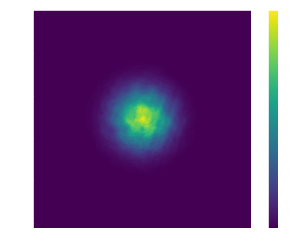

In [35]:
#%matplotlib widget
%matplotlib inline

path_to_load = r"E:\Nonlinear_Optics_LAB\Tiago_Data\Fuid_plus_obstacle_turbulence\measurements_15_06_2022_droplet_new_4f"
 
path_temp = path_to_load +  "\\input_gaussian_beam"
h5py_file_to_load = h5py.File(path_temp, 'r')
input_fluid= h5py_file_to_load["data"][:]
h5py_file_to_load.close()

backgorund = np.mean(input_fluid[:,:10])

input_fluid = input_fluid - backgorund

input_fluid_normalized = input_fluid/np.max(input_fluid)

y_shape, x_shape = np.shape(input_fluid_normalized)

x_center = 368
y_center = 333


input_fluid_normalized_rolled = np.roll(input_fluid_normalized, 
                                        (int(y_shape/2-y_center),int(x_shape/2-x_center)), (0,1))

input_fluid_normalized_rolled_cutted = input_fluid_normalized_rolled[(int(y_shape/2-256)):(int(y_shape/2+256)),
                                                                     (int(x_shape/2-256)):(int(x_shape/2+256))]

input_fluid_normalized_rolled_cutted = np.abs(input_fluid_normalized_rolled_cutted)

plt.figure()

plt.imshow(input_fluid_normalized_rolled_cutted)
plt.colorbar()

print(np.mean(input_fluid_normalized_rolled_cutted[:,:10]))


# y_shape, x_shape = np.shape(input_fluid_normalized_rolled_cutted)
# xx_camera = np.linspace(-0.5, 0.5, x_shape)*3.45e-6*2
# yy_camera = np.linspace(-0.5, 0.5, y_shape)*3.45e-6*2

# fluid_interpolator = interpolate.interp2d(xx_camera, yy_camera, input_fluid_normalized_rolled_cutted, kind='cubic')

# expansion_factor = 1.0

# XX_new = np.linspace(-0.5, 0.5, x_shape)*3.45e-6*2/expansion_factor
# YY_new = np.linspace(-0.5, 0.5, y_shape)*3.45e-6*2/expansion_factor

# fluid_rescaled = fluid_interpolator(XX_new, YY_new)

# input_fluid_normalized_cutted_scalled = np.abs(fluid_rescaled)
    

# plt.figure()
# plt.imshow(np.sqrt(input_fluid_normalized_cutted_scalled))
# plt.colorbar()

# <font color='green'>System characterization</font>

In [62]:
%matplotlib widget
#%matplotlib inline

R = ((2.36-1)/(2.36+1))**2.0
T = 1 - R

#Scaling factor of the power meter
power_meter_factor = 1.34+1.6*0

GL_to_load = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 15000]
angle = [0, 0.00244017, 0.00280785, 0.00476556, 0.00679314, 0.0090616, 0.01050736, 0.01238871, 0.013732, 0.01519613, 0.01677856, 0.02503264]


popt_x_ve, pcov_x = sp.optimize.curve_fit(linear_fit, GL_to_load, angle, p0=[0.001, 0.0])

N_rings_level_2 = [0, 1, 1, 2, 4, 6, 6, 7, 7]
max_or_minimum_level_2 = [1, 0, 1, 1, 0, 0, 1, 1, 1]

delta_phi_level_2 = np.zeros(len(N_rings_level_2))

for i in range(len(delta_phi_level_2)):
    if max_or_minimum_level_2[i]==1:
        delta_phi_level_2[i] = 2.0*N_rings_level_2[i]*np.pi
    else:
        delta_phi_level_2[i] = 2.0*(N_rings_level_2[i]-1)*np.pi
        
k0 = 2.0*np.pi/(532e-9) 
L = 20e-3
delta_n_level_2 = delta_phi_level_2/(k0*L)

power_to_load_level_2 = [0.553, 2.02, 5.86, 12.72, 29.6, 78.1, 192, 512, 961]
intensities_level_2 = 2.0*np.array(power_to_load_level_2)*power_meter_factor*1e-3/(np.pi*(0.0245)**2.0)

intensities_level_2 *= T

delta_n_params, pcov_x = sp.optimize.curve_fit(delta_n_f, intensities_level_2, delta_n_level_2, p0=[1e-4,25])

# <font color='green'>System configuration</font>

In [64]:
power_dictionary = {"0":47.6, "1500":47.2, "2000":46.8, "2500":45.3, "3000":45.6, 
                    "4000":46.0, "4500":46.2, "5000":45.8}


###################################################################################
#Velocity of the fluid
GL = 0

P_green_beam = power_dictionary[str(GL)] #muW
P_green_beam_corrected = power_meter_factor*P_green_beam

#Red beam parameters
P_red_beam = 73.0#muW

#########################################################################################################

P_green_beam_corrected *= T
P_red_beam *= T


norm = np.sum(input_fluid_normalized_cutted_scalled)*(3.45e-6*2.0/expansion_factor)**2.0*1e4

I_fluid = P_green_beam_corrected*1e-3/norm

print(I_fluid)

10.580132439421051


# <font color='green'>Calculate simulation parameters</font>

In [65]:
#light fluid wavelength
lf=532*10**-9

#k_fluid
kf = (2*pi)/lf

#parameters of the crystal
ne = 2.36 #index of refraction n_e
r33 = 235*10**-12 #pm/V
#Biasing electric Field
E0 = 1400*10**2 # V/m

#maximum index variation
#delta_n_max = 0.5*ne**3*r33*E0
delta_n_max = delta_n_params[0]
delta_n = delta_n_f(I_fluid, *delta_n_params)


#absorption
alpha = 100 /(delta_n_max * kf) #1.319 cm^-2
gamma = 1

#healing length
hl = 1/(kf*sqrt(ne*delta_n))

#transverse direction scaling factor
factor_t = kf*sqrt(ne*delta_n_max)

#propagation direction scaling factor
factor_z = kf*delta_n_max


##################################################
#Crystal Size
lx=512*3.45*1e-6*2.0/2 #2.5*10**-3
ly=512*3.45*1e-6*2.0/2 #2.5*10**-3
lz=20*10**-3

#in adimensional units
lx_sim = factor_t*lx
ly_sim = factor_t*ly
lz_sim = factor_z*lz

##################################################

print("I_fluid -> " + str(I_fluid))
print("I_sat -> " + str(delta_n_params[-1]))
print("delta_n -> " + str(delta_n))
print("delta_n_max -> " + str(delta_n_max))
print("lx -> " + str(lx_sim))
print("ly -> " + str(ly_sim))
print("lz -> " + str(lz_sim))
print('healing length - > ' + str(hl))

I_fluid -> 10.580132439421051
I_sat -> 47.01351228990546
delta_n -> 3.604963175478586e-05
delta_n_max -> 0.00019623853442252335
lx -> 448.9577155045865
ly -> 448.9577155045865
lz -> 46.35349910473888
healing length - > 9.179633581783356e-06


# <font color='green'>Create simulation mesh</font>

Define the simulation box parameters

In [66]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 2

#Number of points in x,y transversal dimensions
Nx = 512
Ny = 512

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = lx_sim / Nx
dy = ly_sim / Ny
dt = 1.
print('dx->',dx,'dy->',dy)

#integration parameters

stride = 50
dz = 0.05 #.2
total_steps = int(lz_sim/(stride*dz))
print(total_steps)

#define a directory to save
saveDir = r".turbulence_photorefractive_with_gaussian_image_an_axicon"

if Nx != 512 and Ny!=512:
    print("The fields will be interpolated")
    y_shape, x_shape = np.shape(input_fluid_normalized_rolled_cutted)
    xx_camera = np.linspace(0, x_shape, x_shape)
    yy_camera = np.linspace(0, y_shape, y_shape)

    fluid_interpolator = interpolate.interp2d(xx_camera, yy_camera, input_fluid_normalized_rolled_cutted, kind='cubic')

    XX_new = np.linspace(0, x_shape, Nx)
    YY_new = np.linspace(0, y_shape, Ny)

    fluid_rescaled = fluid_interpolator(XX_new, YY_new)
    
    input_fluid_normalized_cutted_scalled = fluid_rescaled
    
else:
    print("No interpolation")
    #input_fluid_normalized_cutted_scalled = input_fluid_normalized_rolled_cutted

dx-> 0.8768705380948955 dy-> 0.8768705380948955
18
No interpolation


# <font color='green'>Create simulation initial conditions</font>

In [70]:
#Simulation parameters

increase_factor = 1.

d_besse_1 = 89.89e-4*increase_factor
d_besse_2 = 147.74e-4*increase_factor


dd1 = d_besse_1*1e-2*factor_t/2.0
dd2 = d_besse_2*1e-2*factor_t/2.0

fluid_velocity = linear_fit(np.array(GL), *popt_x_ve)/ne

#cs = np.sqrt(1/Isat)
theta = fluid_velocity*ne
vx = theta/ne/np.sqrt(ne*delta_n)
cs = np.sqrt(delta_n/ne)
gamma = 1




Isat = delta_n_params[-1]/I_fluid #mw/cm^-2

print("vx = " + str(vx))
print("vx/cs = " + str(theta/ne/cs))

my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride,dx,dy,dz,dt,0,0, 
                                  alpha, Isat, gamma, saveDir)

#Gaussian field - fluid
my_simulation.initial_condition.add_field(add_field_from_array_with_velocity_normalized(np.sqrt(input_fluid_normalized_cutted_scalled),
                                                                             my_simulation.x_af,
                                                                             my_simulation.y_af, 
                                                                             P_green_beam_corrected*1e-3,
                                                                             I_fluid,
                                                                             my_simulation.Nx*my_simulation.dx/2, 
                                                                             my_simulation.Ny*my_simulation.dy/2,
                                                                             0*vx,
                                                                             0,
                                                                             factor_t))

#Noise
#my_simulation.initial_condition.add_field(whitenoise_2d_field(my_simulation.x_af, 0.1))

#Axicon - optical defect
my_simulation.initial_condition2.add_field(droplet_2d(my_simulation.x_af,
                                                     my_simulation.y_af, 
                                                     2.0*P_red_beam*1e-3,
                                                     I_fluid,
                                                     my_simulation.Nx*dx/2,
                                                     my_simulation.Ny*dy/2, 
                                                     dd1,
                                                     dd2,
                                                     0,
                                                     factor_t))





#how many
number_nl_numbers = 0
#(g, power)
nl_numbers = []
my_simulation.number_nl_numbers = number_nl_numbers

#define the nonlinearities of type vector
#how many
number_nl_vectors = 0
nl_vectors=[]
my_simulation.number_nl_vectors = number_nl_vectors

vx = -0.05994533222739805
vx/cs = -0.1414709840566594


In [71]:
input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)

print("P_measured: ", P_green_beam_corrected)
print("P_numerical: ", np.sum(input_fluid_normalized_cutted_scalled)*dx*dy/factor_t/factor_t*1e4*1e3*I_fluid)
print("\n")
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
print("P_measured: ", P_red_beam) 
print("P_numerical: ", (5/(lx*1e3))**2.0*np.sum(input_axicon_size)*dx*dy/factor_t/factor_t*1e4*1e3*I_fluid)
print("\n")
print(I_fluid)
print(Isat)

P_measured:  53.33412698412699
P_numerical:  13.33353174603175


P_measured:  61.040249433106574
P_numerical:  121.6040876176622


10.580132439421051
4.44356557529804


# <font color='Green'>Test simulation initial conditions</font>

5.828635993946326


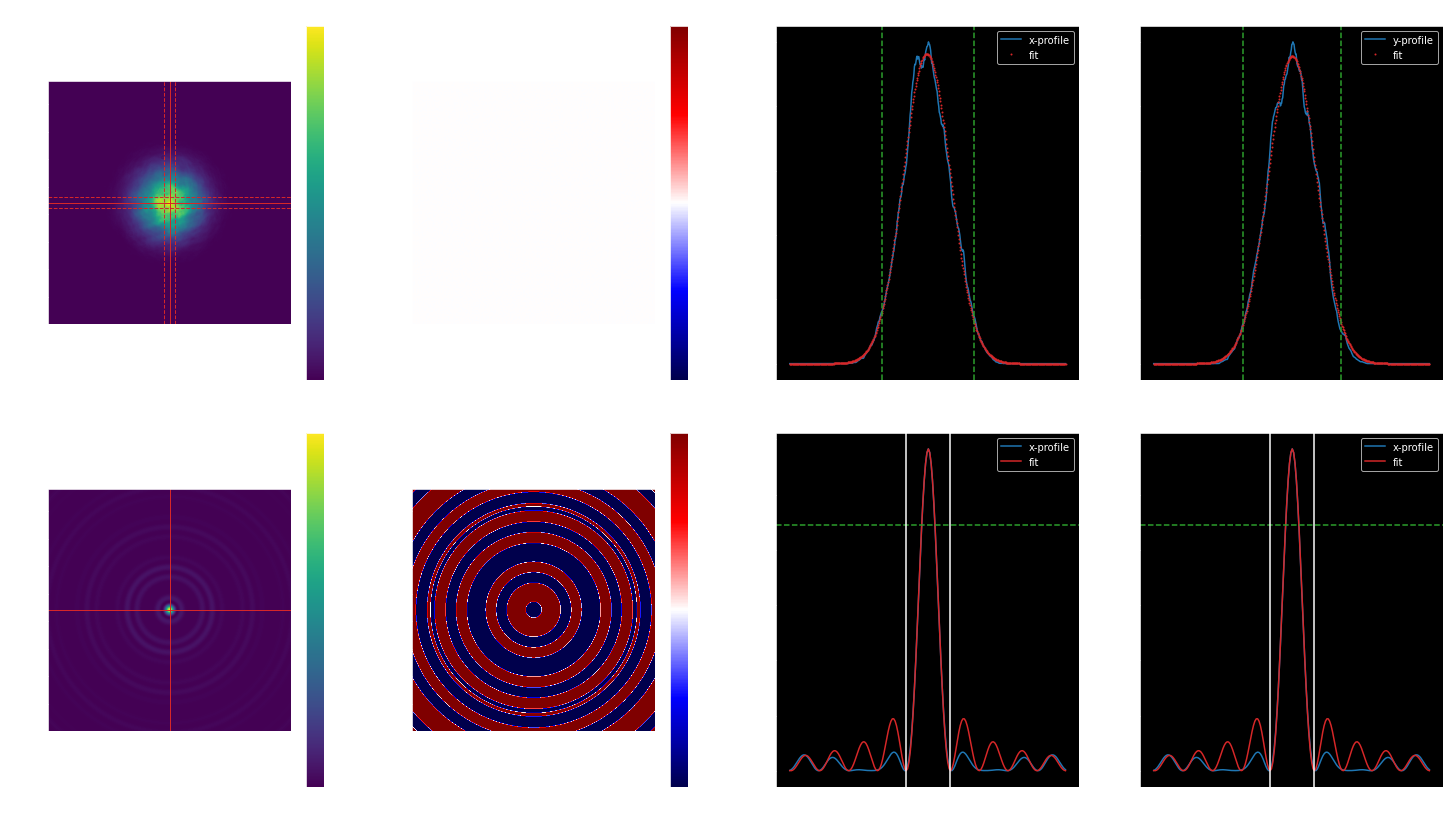

In [72]:
#%matplotlib widget
%matplotlib inline

######################### Gausian

extent_general = [0, Nx*dx/factor_t/(1e-3), 0, Ny*dy/factor_t/(1e-3)]

input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)
phase_input_beam = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition.np_array), np.real(my_simulation.initial_condition.np_array)))


y_shape, x_shape = np.shape(input_beam_profile)

dx_units = 1440 / x_shape
dy_units = 1080 / y_shape

x_center_4f = int(x_shape/2)
y_center_4f = int(y_shape/2)

width_mean = 12

profile_x = input_beam_profile[(y_center_4f-width_mean):(y_center_4f+width_mean), :]
profile_y = input_beam_profile[:, (x_center_4f-width_mean):(x_center_4f+width_mean)]
profile_x = np.mean(profile_x, axis=0)
profile_y = np.mean(profile_y, axis=1)


# profile_x = input_beam_profile[y_center, :]
# profile_y = input_beam_profile[:, x_center]


profile_x = profile_x/np.max(profile_x)
profile_y = profile_y/np.max(profile_y)


x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]

popt_x, pcov_x = sp.optimize.curve_fit(gaus, x_array, profile_x, p0=[1,0,10.0])

popt_y, pcov_y = sp.optimize.curve_fit(gaus, y_array, profile_y, p0=[1,0,10.0])



fig = plt.figure(figsize=(25, 14))

rows = 2
columns = 4

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])
plt.title("Fluid")
plt.imshow(input_beam_profile, extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.axvline(x=(x_center_4f)*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axvline(x=(x_center_4f - width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axvline(x=(x_center_4f + width_mean)*dx/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.axhline(y=(y_center_4f)*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=(y_center_4f - width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")
plt.axhline(y=(y_center_4f + width_mean)*dy/factor_t/(1e-3), color="tab:red", linewidth=1, linestyle="--")

plt.subplot(grid[0, 1])
plt.imshow(phase_input_beam, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[0, 2])
plt.title("$1/e^2$=" + str(np.round(popt_x[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(x_array/factor_t/(1e-3), profile_x, label="x-profile", color="tab:blue")
plt.plot(x_array/factor_t/(1e-3), gaus(x_array, *popt_x),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)

plt.axvline(x=(popt_x[-1] + popt_x[1])/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_x[-1] + popt_x[1])/factor_t/(1e-3), color="tab:green", linestyle="--")

plt.subplot(grid[0, 3])
plt.title("$1/e^2$=" + str(np.round(popt_y[-1]/factor_t/(1e-3),3)) + " mm")
plt.plot(y_array/factor_t/(1e-3), profile_y, label="y-profile", color="tab:blue")
plt.plot(y_array/factor_t/(1e-3), gaus(y_array, *popt_y),'ro:', linewidth=0, markersize=1, label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)

plt.axvline(x=(popt_y[-1] + popt_y[1])/factor_t/(1e-3), color="tab:green", linestyle="--")
plt.axvline(x=-(popt_y[-1] + popt_y[1])/factor_t/(1e-3), color="tab:green", linestyle="--")



#######################          Axicon
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
phase_axicon = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition2.np_array), np.real(my_simulation.initial_condition2.np_array)))

axicon_max = np.max(input_axicon_size)

y_shape, x_shape = np.shape(input_axicon_size)


x_center_4f = int(x_shape/2)
y_center_4f = int(y_shape/2)

fit_width = 100

x_array = np.array(my_simulation.x_af)[:, y_center_4f] - np.array(my_simulation.x_af)[x_center_4f, y_center_4f]
y_array = np.array(my_simulation.y_af)[x_center_4f, :] - np.array(my_simulation.y_af)[x_center_4f, y_center_4f]

profile_x_4f_input_axicon_size = input_axicon_size[y_center_4f, :]
profile_y_4f_input_axicon_size = input_axicon_size[:, x_center_4f]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size[(x_center_4f-fit_width):((x_center_4f+fit_width))]
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size[(y_center_4f-fit_width):((y_center_4f+fit_width))]

profile_x_4f_input_axicon_size_cutted = profile_x_4f_input_axicon_size_cutted/np.max(profile_x_4f_input_axicon_size_cutted)
profile_y_4f_input_axicon_size_cutted = profile_y_4f_input_axicon_size_cutted/np.max(profile_y_4f_input_axicon_size_cutted)

x_array_cutted_4f = x_array[(x_center_4f-fit_width):((x_center_4f+fit_width))]
y_array_cutted_4f = y_array[(y_center_4f-fit_width):((y_center_4f+fit_width))]

popt_x_input_4f, pcov_x_input = sp.optimize.curve_fit(bessel_function, x_array_cutted_4f, profile_x_4f_input_axicon_size_cutted, p0=[0, 10.0])
popt_y_input_4f, pcov_y_input = sp.optimize.curve_fit(bessel_function, y_array_cutted_4f, profile_y_4f_input_axicon_size_cutted, p0= [0, popt_x_input_4f[-1]])

######################################################################################################################################################

plt.subplot(grid[1, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_axicon_size, extent=extent_general)
plt.colorbar()
plt.axvline(x=x_center_4f*dx/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.axhline(y=y_center_4f*dy/factor_t/(1e-3), color="tab:red", linewidth=1)
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 1])

plt.imshow(phase_axicon, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")


plt.subplot(grid[1, 2])
plt.title("$D^x_{obs}$=" + str(2.0*np.round(popt_x_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(x_array_cutted_4f/factor_t/(1e-3), axicon_max*profile_x_4f_input_axicon_size_cutted, label="x-profile", color="tab:blue")
plt.plot(x_array_cutted_4f/factor_t/(1e-3), axicon_max*bessel_function(x_array_cutted_4f, *popt_x_input_4f), label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("x [mm]", fontsize=15)
plt.axhline(y=Isat, linestyle="--", color="tab:green")

plt.axvline(x=popt_x_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_x_input_4f[-1]/factor_t/(1e-3))


plt.subplot(grid[1, 3])
plt.title("$D^y_{obs}$=" + str(2.0*np.round(popt_y_input_4f[-1]/factor_t/(1e-6),1)) + " $\\mu m$")
plt.plot(y_array_cutted_4f/factor_t/(1e-3), axicon_max*profile_y_4f_input_axicon_size_cutted, label="x-profile", color="tab:blue")
plt.plot(y_array_cutted_4f/factor_t/(1e-3), axicon_max*bessel_function(y_array_cutted_4f, *popt_y_input_4f), label='fit', color="tab:red")
plt.legend(loc=0)
plt.xlabel("y [mm]", fontsize=15)
plt.axhline(y=Isat, linestyle="--", color="tab:green")

plt.axvline(x=popt_y_input_4f[-1]/factor_t/(1e-3))
plt.axvline(x=-popt_y_input_4f[-1]/factor_t/(1e-3))

plt.tight_layout()

print(np.max(input_axicon_size))


# <font color='blue'>Generate Configuration file</font>

In [73]:
my_simulation.gen_config_file(nl_numbers,nl_vectors)

**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!


# <font color='blue'>Set device to compute</font>

In [74]:
af.device.set_device(0)
af.device.device_info()

{'device': 'GeForce_GTX_TITAN',
 'backend': 'OpenCL',
 'toolkit': 'NVIDIA CUDA',
 'compute': '1.2'}

# <font color='blue'>Run Simulation</font>

Having the engine built previously and added to the folder we can call from the command line to execute it.

Options:

First argument corresponds to backend: 1 - CPU; 2 - OpenCl; 3 - CUDA;

Second argument corresponds to device: 0 - #number of devices available to choose the device

In [75]:
%%cmd
hibpm_run.exe 2 0 

Microsoft Windows [Version 10.0.19044.1706]
(c) Microsoft Corporation. All rights reserved.

(LAB_env) E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\SBN>hibpm_run.exe 2 0 
Running info
Creating a mesh for our problem 
---Mesh created--- 
---scalar field created--- 
---start--- 
Stride 0 of 18 aqui:0.05
aqui
update Stride 1 of 18 aqui:0.05
aqui
update Stride 2 of 18 aqui:0.05
aqui
update Stride 3 of 18 aqui:0.05
aqui
update Stride 4 of 18 aqui:0.05
aqui
update Stride 5 of 18 aqui:0.05
aqui
update Stride 6 of 18 aqui:0.05
aqui
update Stride 7 of 18 aqui:0.05
aqui
update Stride 8 of 18 aqui:0.05
aqui
update Stride 9 of 18 aqui:0.05
aqui
update Stride 10 of 18 aqui:0.05
aqui
update Stride 11 of 18 aqui:0.05
aqui
update Stride 12 of 18 aqui:0.05
aqui
update Stride 13 of 18 aqui:0.05
aqui
update Stride 14 of 18 aqui:0.05
aqui
update Stride 15 of 18 aqui:0.05
aqui
update Stride 16 of 18 aqui:0.05
aqui
update Stride 17 of 18 aqui:0.05
aqui
update Total elapsed time 	5858
ArrayFire v3.6.4 (

# <font color='green'>Load data</font>

In [76]:
#load the simulation mesh - here we use the data generated , deprecating the previous generated data; 
#they are equivalent, but this way you can adapt the same codes to simulations generated from pure c++ simulations

#load the simulation mesh
my_mesh = mesh(saveDir+"/")

#load the data from data folder
#stride between consecutive loaded files
stride_read = 1
simulation_data,zs = load_data_folder(saveDir+"/gnlse_field/",my_mesh,stride_read)
simulation_data2,zs = load_data_folder(saveDir+"/gnlse_field2/",my_mesh,stride_read)

# <font color='green'>Plot results</font>

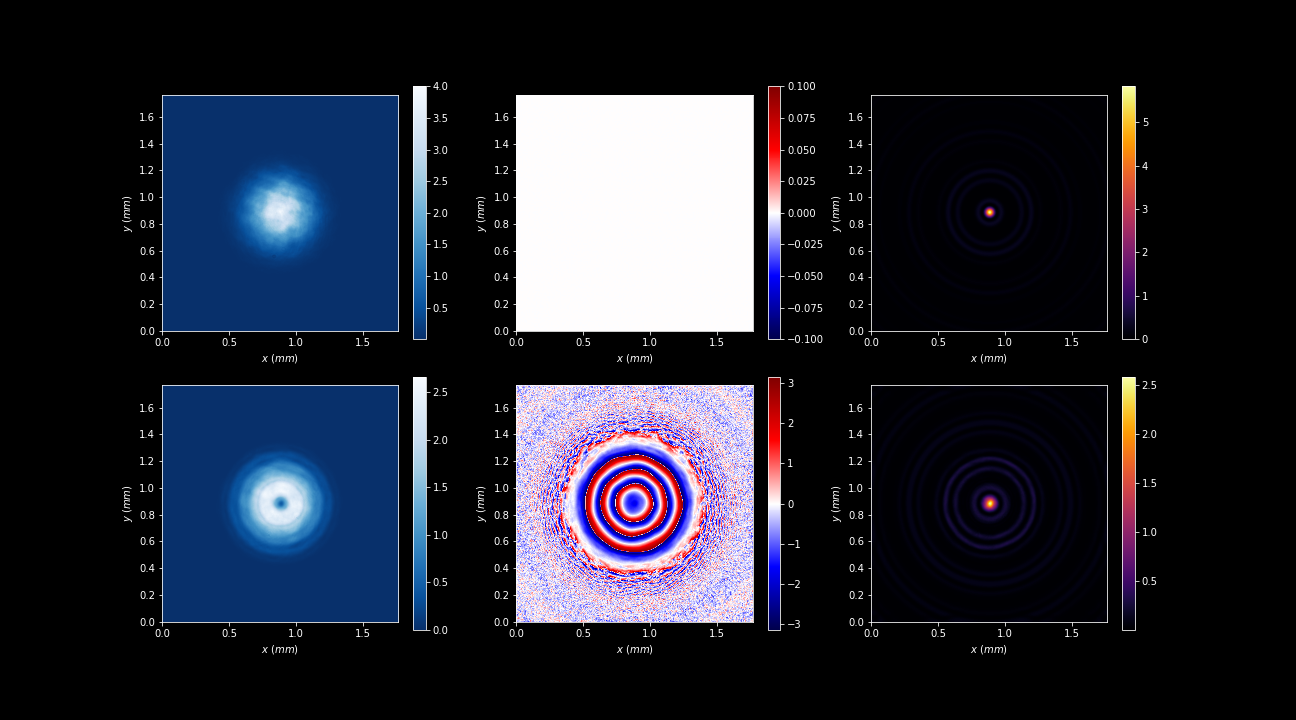

In [77]:
%matplotlib widget
#%matplotlib inline

fig = plt.figure(figsize=(18, 10))

rows = 2
columns = 3

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

extent_general = [0, my_mesh.lx/factor_t/(1e-3),0,my_mesh.ly/factor_t/(1e-3)]

plt.subplot(grid[0, 0])

im = imshow(transpose(abs(simulation_data[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 1])
phase = np.arctan2(np.imag(simulation_data[0]), np.real(simulation_data[0]))
im = imshow(transpose(phase), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 2])
im1 = imshow(transpose(abs(simulation_data2[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

plt.subplot(grid[1, 0])
im = imshow(transpose(abs(simulation_data[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 1])
phase = np.arctan2(np.imag(simulation_data[-1]), np.real(simulation_data[-1]))
im = imshow(transpose(phase), origin = "lower",extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 2])
im1 = imshow(transpose(abs(simulation_data2[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

fig.tight_layout()

# <font color='green'>Plot results - arround the defect</font>

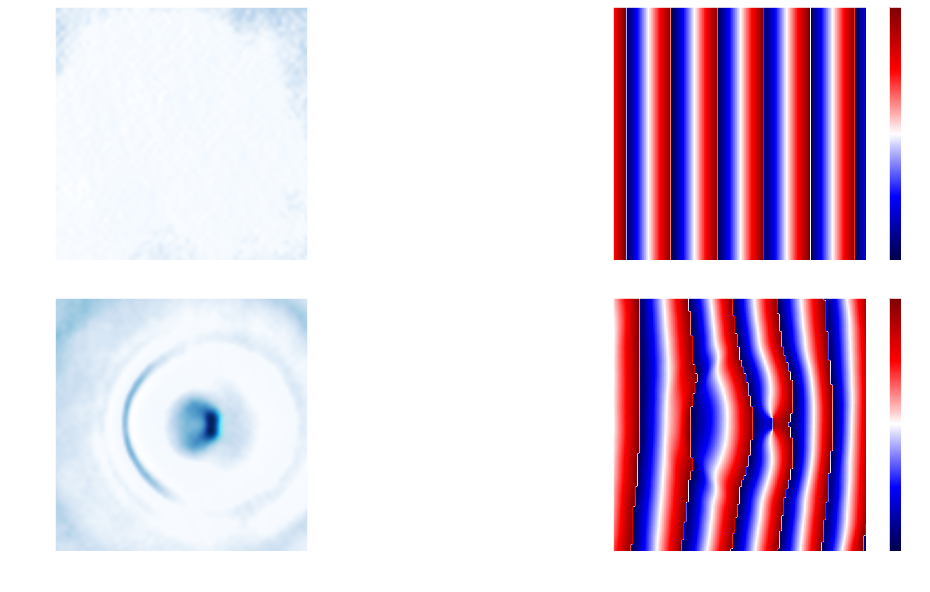

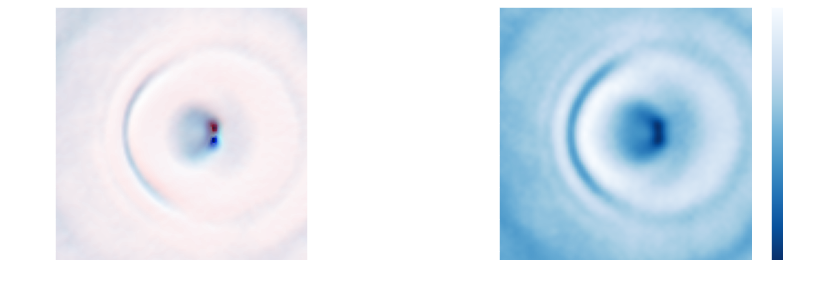

In [244]:
#%matplotlib widget
%matplotlib inline

x_center = my_mesh.lx/factor_t/(1e-3)/2.0
y_center = my_mesh.ly/factor_t/(1e-3)/2.0

width_arround_defect = 50
width_arround_defect = width_arround_defect/factor_t/(1e-3)

fig = plt.figure(figsize=(18, 10))

rows = 2
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

extent_general = [0, my_mesh.lx/factor_t/(1e-3),0,my_mesh.ly/factor_t/(1e-3)]

plt.subplot(grid[0, 0])

data_temp = transpose(abs(simulation_data[0])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)

xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[0, 1])
phase = np.arctan2(np.imag(simulation_data[0]), np.real(simulation_data[0]))
im = imshow(transpose(phase), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[1, 0])
data_temp = transpose(abs(simulation_data[-1])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0.0, vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[1, 1])
phase = np.arctan2(np.imag(simulation_data[-1]), np.real(simulation_data[-1]))
im = imshow(np.transpose(phase), origin = "lower",extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)
plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

fig = plt.figure(figsize=(15, 10))

rows = 1
columns = 2

plt.subplot(grid[0, 0])
data_temp = transpose(abs(simulation_data[-1])**2)
data_temp = data_temp/np.max(data_temp)
ls = LightSource(azdeg=3155,altdeg=45)
cmap = plt.cm.Blues_r
rgb = ls.shade(data_temp, cmap = cmap, vmin=0., vmax=0.7,)
img = plt.gca().imshow(rgb,interpolation='bilinear', extent = extent_general)

vorticity = get_vorticity(np.transpose(simulation_data[-1]), my_mesh.dx, my_mesh.dy)

plt.imshow(vorticity, cmap="seismic", extent = extent_general, 
       aspect = "equal", alpha=0.5)

#im = imshow(np.transpose(phase), origin = "lower",extent = extent_general, 
#aspect = "equal", cmap = 'seismic', alpha=0.5)

xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")

plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

plt.subplot(grid[0, 1])
im = imshow(transpose(abs(simulation_data[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)


XX, YY = np.meshgrid(np.linspace(0, extent_general[1], x_shape), np.linspace(0, extent_general[-1], y_shape))
px, py = get_momentum_vector_2d(np.transpose(simulation_data[-1]), my_mesh.dx/factor_t, my_mesh.dy/factor_t)

arrays = np.where( ((XX>=(x_center - width_arround_defect))&(XX<=(x_center + width_arround_defect)))&
                   ((YY>=(y_center - width_arround_defect))&(YY<=(y_center + width_arround_defect))) )


XX_cutted = XX[arrays]
YY_cutted = YY[arrays]
px_cutted = px[arrays]
py_cutted = py[arrays]

shape = int(np.sqrt(np.shape(XX_cutted)[0]))

XX_cutted = np.reshape(XX_cutted,(shape, shape))
YY_cutted = np.reshape(YY_cutted,(shape, shape))
px_cutted = np.reshape(px_cutted,(shape, shape))
py_cutted = np.reshape(py_cutted,(shape, shape))

#plt.streamplot(XX_cutted, YY_cutted, px_cutted, py_cutted, color="k", linewidth=0.6, density=2, arrowsize=0.5)

plt.xlim(xmin = x_center - width_arround_defect, xmax = x_center + width_arround_defect)
plt.ylim(ymin = y_center - width_arround_defect, ymax = y_center + width_arround_defect)

fig.tight_layout()



NameError: name 'XX' is not defined

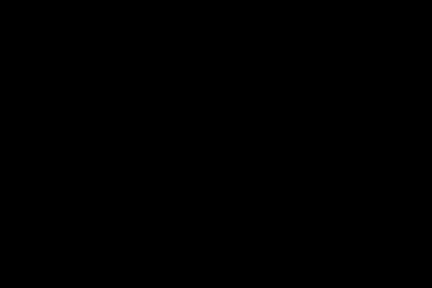

In [78]:
%matplotlib widget
kx = 300
ky = 400
plt.figure()
im = imshow(transpose(abs(simulation_data[-1] + np.exp(1.0j*kx*XX + 1.0j*ky*YY))**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

In [246]:
interferogram_temp = transpose(abs(simulation_data[-1] + 2.0*np.exp(1.0j*kx*XX + 1.0j*ky*YY))**2)
   
  
y_shape, x_shape = np.shape(interferogram_temp)

XX, YY = np.meshgrid(np.linspace(0, x_shape, x_shape), np.linspace(0, y_shape, y_shape))

data_fft = fftshift(fft2(interferogram_temp))

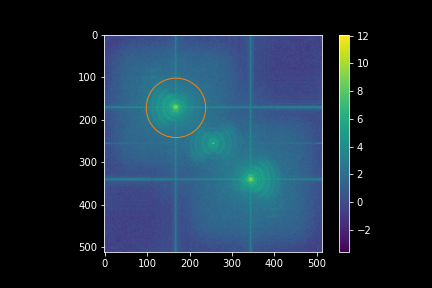

In [248]:
fft_x_center = 168
fft_y_center = 172
filter_radius = 70

plt.figure()
plt.imshow(np.log10(np.abs(data_fft)**2.0))
plt.colorbar()

circle = plt.Circle((fft_x_center, fft_y_center), filter_radius, color='tab:orange', fill=False)

plt.gca().add_patch(circle)

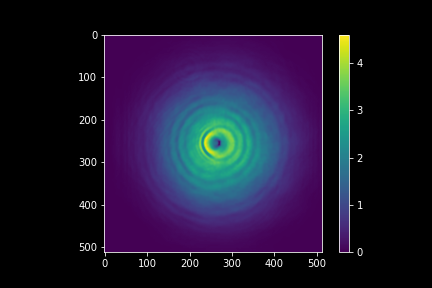

In [249]:

data_rolled_and_filtered = np.roll(data_fft, (int(y_shape/2.0) - fft_y_center, int(x_shape/2.0) - fft_x_center), (0,1))

a = x_shape/y_shape
b = 1.0

positions_to_filter = np.where(((XX-x_shape/2.0)**2.0/a**2.0 + (YY-y_shape/2.0)**2.0/b**2.0)>filter_radius**2.0)

data_rolled_and_filtered[positions_to_filter] = 0

data_reconstructed = ifft2(fftshift(data_rolled_and_filtered))

plt.figure()
plt.imshow(np.abs(data_reconstructed)**2.0)
plt.colorbar()


In [55]:
defect_profile_x = []
defect_profile_y = []
for i in range(len(simulation_data2)):
    defect_temp = np.transpose(np.abs(simulation_data2[i])**2.0)
    
    x_center = int(x_shape/2)
    y_center = int(y_shape/2)
    
    defect_profile_x.append(defect_temp[y_center,:])
    defect_profile_y.append(defect_temp[:,x_center])
    
defect_profile_x = np.transpose(defect_profile_x)
defect_profile_y = np.transpose(defect_profile_y)


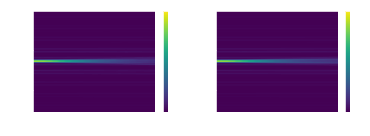

In [21]:
fig = plt.figure()

rows = 1
columns = 2

plt.subplot(grid[0, 0])
plt.imshow(defect_profile_x, aspect="auto")
plt.colorbar()

plt.subplot(grid[0, 1])
plt.imshow(defect_profile_y, aspect="auto")
plt.colorbar()

plt.tight_layout()

# <font color='blue'>Plot incompressible kinetic energy</font>

In [30]:
k_collection = []
E_incom_collection = []

manager = enlighten.get_manager()
ticks = manager.counter(total=len(simulation_data), desc="Calculating data", unit="it", color="blue")

for i in range(len(simulation_data)):

    r_temp, Eci_temp, ecc_temp = get_field_turbulence_properties_single_field(np.transpose(simulation_data[i]), my_mesh.dx/factor_t, my_mesh.dx/factor_t, k_n=128)
    
    k_collection.append(r_temp[1:])
    E_incom_collection.append(Eci_temp[1:])
    
    ticks.update()
        
manager.stop()

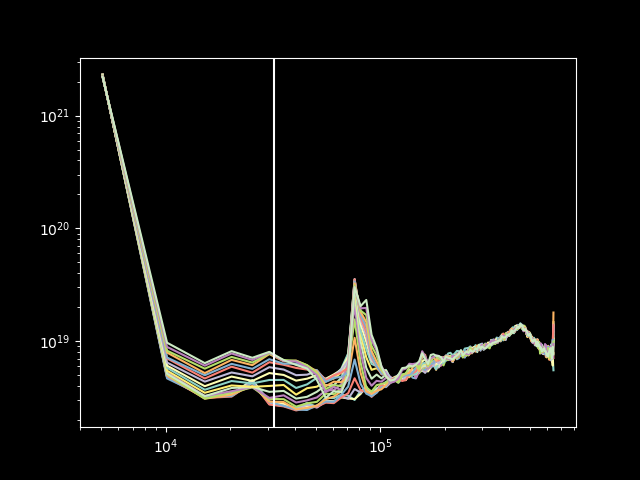

In [35]:
plt.figure()
for i in range(len(simulation_data)):
    plt.plot(k_collection[i], E_incom_collection[i])
    
plt.axvline(x=2.0*np.pi/(width_arround_defect*1e-3))  
    
plt.xscale("log")
plt.yscale("log")

In [303]:
factor_t

254165.3736342451